# Determine all stellar properties, i.e. Teff, R, L from photometry, empirical relations and spectra
## Create plots for paper and tables for analysis and AltaiPony input list

In [1]:
from copy import copy

import numpy as np
import pandas as pd

import specmatchemp.library

from opencluster.lum import remove_outlier_Teffs, read_Kepler_response
from opencluster.opencluster import OpenCluster

from opencluster.paperplots import (import_matplotlib_style,
                                    plot_interconnected_subplots,
                                    MARKERS_LIST,
                                    CB_COLOR_CYCLE)

from gaia.gaia import calculate_distance_from_parallax

import matplotlib.pyplot as plt
%matplotlib inline
import_matplotlib_style()

from matplotlib import rcParams
rcParams["errorbar.capsize"] = .0

## Define all the plot functions

In [2]:
def plot_Teff_spread(df, figsize=(9,7), outdir="plots/", kpmax=9.):
    
    # define a DataFrame with Teffs only
    df = df[((df["KEP Mag"].isnull()) | (df["KEP Mag"] > kpmax))] # do not plot above saturation level
    cols = df.columns.str.contains("Teff_")
    colvals = df.columns.values[df.columns.str.startswith("Teff_")]
    Teffs = df.loc[:,cols]
    Teffs["Teff_median"] = df.Teff_median
    
    # set layout and labels
    markers = copy(MARKERS_LIST)
    colors = copy(CB_COLOR_CYCLE)
    cdict = dict(zip(list("grizy"),[i + "_SDSS" for i in list("grizy")]))
    c2 = dict(zip(list("JHK"),[i + "_2MASS" for i in list("JHK")]))
    c3 = dict(zip(["BP","RP"],[i + "_Gaia_corr" for i in ["BPRP","BPRP"]]))
    cdict.update(c2)
    cdict.update(c3)
    
    # create a DataFrame with colors and Teffs to plot
    i=0
    xs, ys, xr, yr = [], [], [], []
    dd = pd.DataFrame()
    for c in colvals[0:-2]:
        if ~(Teffs[c].isnull().all()):
            cl = " - ".join(c.split("_")[1:])
            if "Mann" in cl:
                col1, col2 = c.split("_")[2:4]
                col1, col2 = cdict[col1],cdict[col2]
                if col1==col2:
                    x = df[col1]
                    cl = "BP - RP (Mann)"
                    xerr = df["e_" + col1]
                else:
                    
                    x= df[col1]-df[col2]
                    xerr = np.sqrt(df["e_" + col1]**2 + df["e_" + col2]**2)
            elif ("StarHorse" in cl) or ("Apsis" in cl):
                exten = cl.split("_")[-1]
                cl = "BP - RP ({})".format(exten)
                x = df.BP_Gaia - df.RP_Gaia
                xerr = np.sqrt(df.e_BP_Gaia**2 + df.e_RP_Gaia**2)
            else:
                col1, col2 = c.split("_")[1:3]
                col1, col2 = cdict[col1],cdict[col2]
                x= df[col1]-df[col2]
                xerr = np.sqrt(df["e_" + col1]**2 + df["e_" + col2]**2)
            
            cl = cl.replace("Mann - ", "")
            cl = cl.replace("- Boy", "")
            cl = cl.replace(" - FeH", "")
            for j in range(5):
                cl = cl.replace(" - {}".format(j)," ({})".format(j))
            dd[cl] = x
            dd["e_" + cl] = xerr
            dd["y"+str(i)] = Teffs[c]
            dd["e_y"+str(i)] = Teffs["e_" + c]
            xs.append(cl)
            ys.append("y" + str(i))
            xr.append("e_" + cl) 
            yr.append("e_y"+str(i))
            i +=1
            
    #plot the thing
    fig, axes = plot_interconnected_subplots(dd,xs,ys,err=True,
                                             xerr=xr,yerr=yr,
                                             width=2.5, height=6,alpha=.05)
    axes[0].set_ylabel(r"$T_\mathrm{eff}$ [K]")
    for i, ax in enumerate(axes):
        ax.set_xlabel(xs[i])
    plt.subplots_adjust(wspace=0.05, left=0.05, right=0.95)
    plt.savefig("{}{}_Teff_spread_all.png".format(outdir,r.cluster), dpi=300)    
    
    
def plot_Teff_R(df, figsize=(9,7), outdir="plots/"):
    plt.figure(figsize=figsize)
    plt.errorbar(x=df.Teff_median,xerr=df.Teff_std,c="k",
                     y=df.Rstar, yerr=df.e_Rstar, fmt="o", markersize=1, linewidth=.2)
    plt.title(r.h_cluster)
    plt.xlim(7000, 2700)
    plt.ylim(.1,1.7)
    plt.xlabel(r"$T_{\mathrm{eff}}$ [K]")
    plt.ylabel(r"$R_* / R_{\odot}$")
    plt.savefig("{}{}_Teff_R.png".format(outdir,r.cluster), dpi=300)

## Now loop over each cluster and save some plots and tables

In [3]:
# First, read some ancillary data
Kp = read_Kepler_response()
lib = specmatchemp.library.read_hdf(wavlim=[Kp.wav.min(),Kp.wav.max()]) #takes a little while

Reading library from /home/eilin/.specmatchemp/library.h5


# Cluster luminosities and other properties

In [4]:
path = "../FlareAnalysisPipeline/opencluster/clusters"
pd.read_csv('{}/cluster_parameters_merged.csv'.format(path))

,cluster,h_cluster,age (Myr),FeH,dist (pc),u_age_high,u_age_low,u_feh
0,hyades,Hyades,690.0,0.130,46.0,160.0,100.0,0.020
1,ngc2168,M35,147.5,-0.210,861.0,13.5,13.5,0.100
2,ngc2682,M67,3639.0,-0.102,908.0,17.0,17.0,0.081
3,ngc6774,Rup 147,2650.0,0.080,305.0,380.0,380.0,0.070
4,pleiades,Pleiades,135.0,-0.037,135.6,25.0,25.0,0.030
5,praesepe,Praesepe,750.0,0.160,185.5,3.0,7.0,0.000


cluster       ngc2168
h_cluster         M35
age (Myr)       147.5
FeH             -0.21
dist (pc)         861
u_age_high       13.5
u_age_low        13.5
u_feh             0.1
Name: 1, dtype: object
Number of Teff_g_r_Boy  128
Number of Teff_g_z_Boy  152
Number of Teff_g_i_Boy  152
Number of Teff_g_J_Boy  150
Number of Teff_g_H_Boy  150
Number of Teff_g_K_Boy  150
Number of Teff_Mann_BP_RP_nan  157
Number of Teff_Mann_r_z_nan  152
Number of Teff_Mann_r_J_nan  151
Number of Teff_Mann_BP_RP_FeH  157
Number of Teff_Mann_r_z_FeH  152
Number of Teff_Mann_r_J_FeH  151
Number of Teff_Mann_BP_RP_isJH  156
Number of Teff_Mann_r_z_isJH  151
Number of Teff_Mann_r_J_isJH  151
0      164.989380
1       91.502748
2      157.336228
3      100.885719
4      387.877967
          ...    
154     95.154335
155     99.521045
156     93.603793
157    190.987446
158      0.000000
Length: 157, dtype: float64
Number of Teff_median:  155
Number of Rstar:  153
number of SEDs:  155
cluster       ngc2682
h_cluste

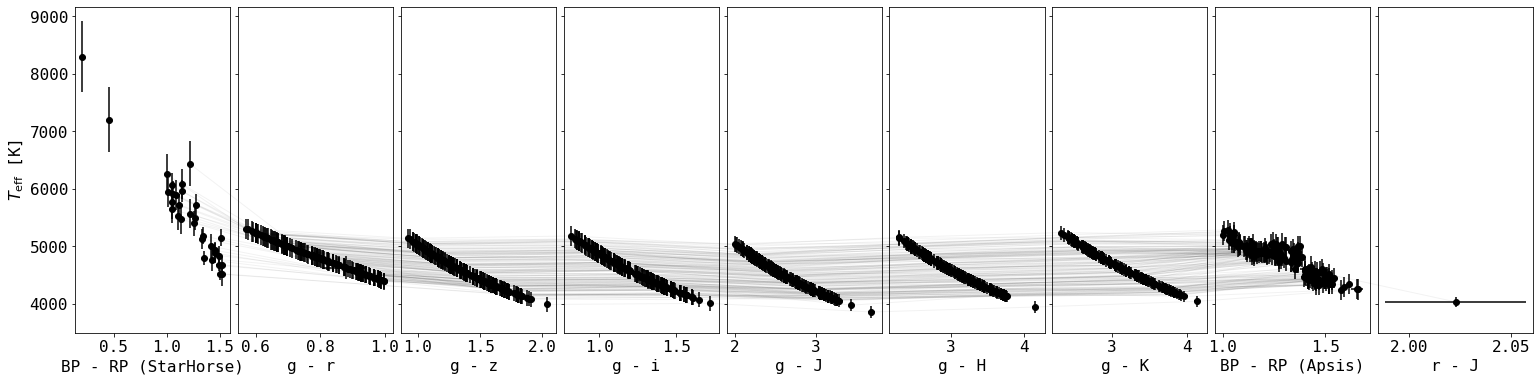

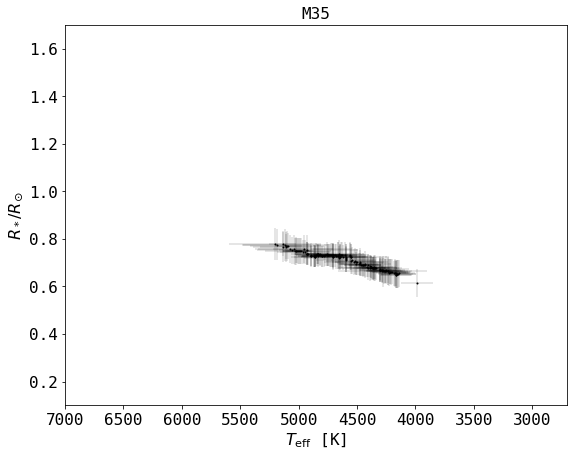

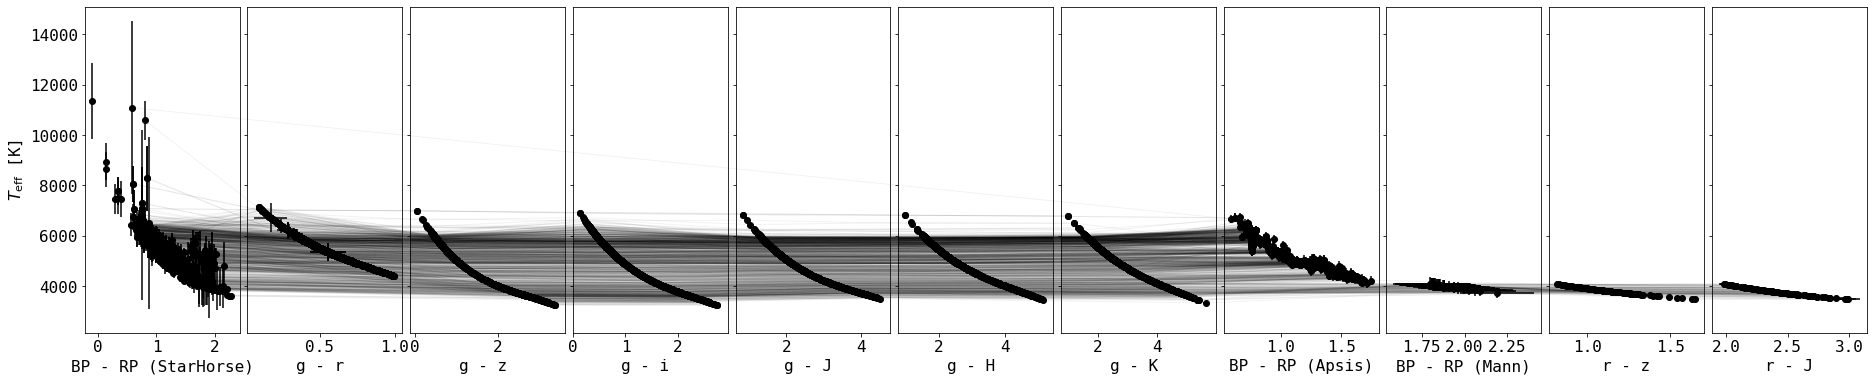

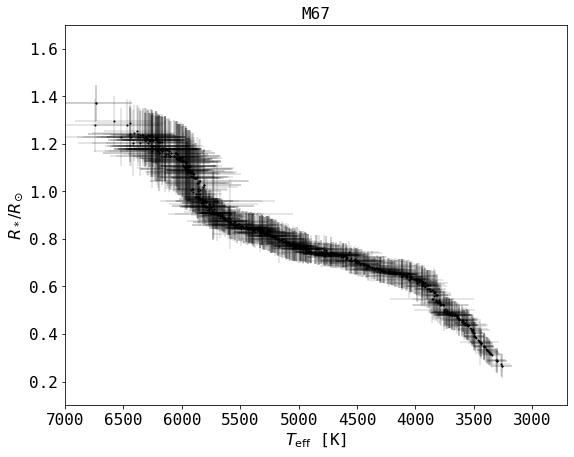

In [6]:
clusters = ["pleiades", "hyades", "praesepe", "ngc6774", "ngc2168", "ngc2682"]
cl = pd.read_csv('{}/cluster_parameters_merged.csv'.format(path))
for cluster in clusters[4:]:
    #Read in the cluster parameters
    
    r = cl[cl.cluster == cluster].iloc[0]
    print(r)
    # Init an OpenCluster

    stellar_parameters = pd.read_csv('cmd/cmd_flagged/{}_cmd.csv'.format(r.cluster))
    OC = OpenCluster(cluster=r.cluster, h_cluster=r.h_cluster, age=r["age (Myr)"],
                         u_age_high=r.u_age_high, u_age_low=r.u_age_low,
                         stars=stellar_parameters, feh=r.FeH, u_feh=r.u_feh,
                         distance=r["dist (pc)"], prep=False)

    # Throw out stars that are obviously foreground object
    dft = OC.stars.loc[:,OC.stars.columns.str.contains("Gaia")].rename(columns = lambda x : str(x)[:-5])
    dft = calculate_distance_from_parallax(dft, check_GoF=False)
    OC.stars = OC.stars[dft.distance > 0.5 * OC.distance]
    
    if cluster == "ngc2682":
        OC.stars["RAJ2000__Gaia"] = OC.stars['ra_epoch2000_Gaia'].values  
        OC.stars["DEJ2000__Gaia"] = OC.stars['dec_epoch2000_Gaia'].values

    OC.determine_Teff()

    # Find R_*:

    OC.find_Rstar(lib)

    # Find SED:

    h = OC.find_SED(lib)

    # Calculate the luminosities:

    OC.calculate_luminosities()
    
    # plot all the things:
    
    plot_Teff_spread(OC.stars)
    plot_Teff_R(OC.stars)
    
    #Save stellar parameters, all of them!
    OC.stars.to_csv('luminosities/{}_luminosities.csv'.format(r.cluster), index=False)

    #However, minimum requirement to be included into the AltaiPony list is to have a Teff value assigned.
    # This Teff values must correspond to a star with SpT > F4 and not be saturated in the Kepler detector
    altai = OC.stars.loc[(~OC.stars.Teff_median.isnull()) &
                         ((OC.stars["KEP Mag"].isnull()) | (OC.stars["KEP Mag"] > 9.)) &
                         (OC.stars["Teff_median"] < 7000.),
                         ['EPIC', 'Channel', 'Campaign']].fillna(0).astype(int).drop_duplicates()
    altai.to_csv('altai/{}_altai.csv'.format(r.cluster), index=False)